# Walmart Weekly Sales Forecasting
### End-to-End Time Series Machine Learning Project

**Objective:**
Forecast weekly department-level sales for Walmart stores using historical sales, promotions, store attributes, and macroeconomic indicators.

**Why this matters:**
Accurate demand forecasting helps retailers reduce stockouts, optimize inventory, and plan promotions more effectively.

## 1. Environment Setup & Library Imports
This section loads all required Python libraries for data manipulation, visualization, and machine learning.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

## 2. Data Loading & Integration

Multiple datasets are combined to create a unified analytical table:
- **Train/Test:** Weekly sales by Store-Department
- **Features:** Promotions, fuel price, CPI, unemployment
- **Stores:** Store size and type

All datasets are merged using Store, Date, and Holiday flags to preserve business context.

In [4]:
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")
df_features = pd.read_csv("../data/raw/features.csv")
df_stores = pd.read_csv("../data/raw/stores.csv")

In [6]:
df_train = df_train.merge(df_features, on=["Store", "Date", "IsHoliday"], how="left")
df_train = df_train.merge(df_stores, on="Store", how="left")

df_test = df_test.merge(df_features, on=["Store", "Date", "IsHoliday"], how="left")
df_test = df_test.merge(df_stores, on="Store", how="left")

## 3. Feature Engineering

This step transforms raw data into model-ready features by:
- Extracting time-based features (Year, Month, Week)
- Treating missing MarkDown values as "no promotion"
- Preserving time continuity using store-wise imputation
- Encoding categorical variables numerically

These transformations help the model capture seasonality, promotions, and store behavior.

In [9]:
def feature_engineer(df):
    df = df.copy()

    # Convert date
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

    # Time features
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

    # Handle MarkDowns (missing = no promotion)
    markdown_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]
    df[markdown_cols] = df[markdown_cols].fillna(0)

    # CPI & Unemployment: fill within each store
    for col in ["CPI", "Unemployment"]:
        df[col] = df.groupby("Store")[col].ffill().bfill()

    # Encode categorical
    df["Type"] = df["Type"].map({"A": 0, "B": 1, "C": 2})
    df["IsHoliday"] = df["IsHoliday"].astype(int)

    return df

In [10]:
df_train = feature_engineer(df_train)
df_test = feature_engineer(df_test)

## 4. Time-Series Feature Creation (Lag & Rolling Statistics)

Retail demand strongly depends on recent sales behavior.
To capture short-term momentum and seasonality:
- `lag_1`: Sales from previous week
- `lag_4`: Sales from same period last month
- `rolling_mean_4`: Smoothed 4-week demand trend

Rows with insufficient history are dropped to avoid data leakage.

In [11]:
df_train = df_train.sort_values(["Store", "Dept", "Date"])

df_train["lag_1"] = df_train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
df_train["lag_4"] = df_train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)

df_train["rolling_mean_4"] = (
    df_train.groupby(["Store", "Dept"])["Weekly_Sales"]
    .shift(1)
    .rolling(4)
    .mean()
)

# Drop rows created by lagging
df_train = df_train.dropna()

## 5. Feature Selection & Temporal Train–Validation Split

Only business-relevant features are selected for modeling.
A **time-based split** is used instead of random sampling to mimic real-world forecasting:
- Training data: before 2012
- Validation data: 2012 onwards

This prevents future data leakage and ensures realistic performance evaluation.


In [12]:
FEATURES = [
    "Store", "Dept", "Size", "Type",
    "Temperature", "Fuel_Price",
    "CPI", "Unemployment",
    "MarkDown1", "MarkDown2", "MarkDown3",
    "MarkDown4", "MarkDown5",
    "IsHoliday",
    "Year", "Month", "Week",
    "lag_1", "lag_4", "rolling_mean_4"
]

TARGET = "Weekly_Sales"

X = df_train[FEATURES]
y = df_train[TARGET]

In [13]:
split_date = "2012-01-01"

X_train = X[df_train["Date"] < split_date]
y_train = y[df_train["Date"] < split_date]

X_val = X[df_train["Date"] >= split_date]
y_val = y[df_train["Date"] >= split_date]

## 6. Model Selection & Training

A **Random Forest Regressor** is chosen because:
- It captures non-linear relationships
- Handles mixed feature types well
- Requires minimal scaling
- Provides interpretability through feature importance

Hyperparameters are tuned to balance performance and overfitting.

In [14]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

## 7. Model Evaluation (Validation Set)

Model performance is evaluated using **Mean Absolute Error (MAE)**, a business-friendly metric that represents average dollar error per week.
Negative predictions are clipped to zero to maintain realistic sales values.

In [15]:
val_preds = model.predict(X_val)
val_preds = np.maximum(0, val_preds)

mae = mean_absolute_error(y_val, val_preds)
print(f"Validation MAE: ${mae:,.2f}")

Validation MAE: $1,495.16


## 8. Feature Importance Analysis

Feature importance helps translate model results into business insights.
It identifies which variables most strongly influence weekly sales and guides strategic decision-making.

In [16]:
importance = pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

importance.head(10)

lag_1             0.757797
rolling_mean_4    0.188968
lag_4             0.020759
Week              0.012058
Dept              0.006230
MarkDown3         0.003875
Temperature       0.001629
Unemployment      0.001343
IsHoliday         0.001261
CPI               0.001069
dtype: float64

Recent sales history (previous week and 4-week rolling average) is the strongest predictor of demand, indicating strong short-term seasonality and purchase momentum. Macroeconomic variables (CPI, unemployment) have minimal short-term impact at weekly granularity.

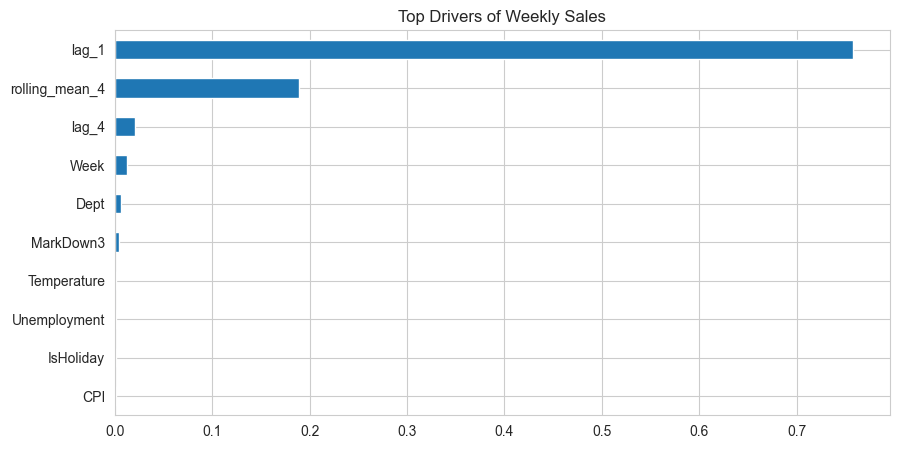

In [17]:
importance.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top Drivers of Weekly Sales")
plt.show()

## 9. Baseline Comparison: Naive Forecast
To validate model usefulness, performance is compared against a simple baseline:
**“Next week sales = last week sales”**
This establishes whether machine learning adds measurable value beyond intuition.


In [18]:
# ================================
# BASELINE MODEL: LAST WEEK SALES
# ================================

# Baseline prediction = lag_1 (previous week's sales)
baseline_preds = X_val['lag_1'].values

# Ensure no negative predictions
baseline_preds = np.maximum(0, baseline_preds)

# Calculate MAE for baseline
baseline_mae = mean_absolute_error(y_val, baseline_preds)

print(f"Baseline MAE (Last Week Sales): ${baseline_mae:,.2f}")
print(f"Random Forest MAE:              ${mae:,.2f}")
print(f"Improvement:                    ${baseline_mae - mae:,.2f}")

Baseline MAE (Last Week Sales): $1,718.39
Random Forest MAE:              $1,495.16
Improvement:                    $223.23


In [22]:
improvement = (baseline_mae - mae) / baseline_mae * 100
print(f"MAE improvement over baseline: {improvement:.2f}%")

MAE improvement over baseline: 12.99%


## 10. Holiday vs Non-Holiday Performance
Sales behavior differs significantly during holidays.
Model performance is evaluated separately to understand forecasting reliability during high-variance periods.

In [23]:
holiday_mask = X_val["IsHoliday"] == 1

mae_holiday = mean_absolute_error(
    y_val[holiday_mask],
    val_preds[holiday_mask]
)

mae_nonholiday = mean_absolute_error(
    y_val[~holiday_mask],
    val_preds[~holiday_mask]
)

print("Holiday MAE:", mae_holiday)
print("Non-Holiday MAE:", mae_nonholiday)

Holiday MAE: 1793.8918322166235
Non-Holiday MAE: 1480.4948828030003


In [ ]:
# ================================
# ACTUAL vs PREDICTED DATAFRAME
# ================================

val_results = X_val.copy()
val_results['Actual_Sales'] = y_val.values
val_results['Predicted_Sales'] = val_preds

# Reattach Store & Dept for filtering
val_results['Store'] = df_train.loc[X_val.index, 'Store']
val_results['Dept'] = df_train.loc[X_val.index, 'Dept']

## 11. Actual vs Predicted Sales (Visual Validation)
A Store–Department example is plotted to visually inspect:
- Trend alignment
- Forecast stability
- Error behavior over time
This ensures the model captures real demand patterns, not just numerical accuracy.

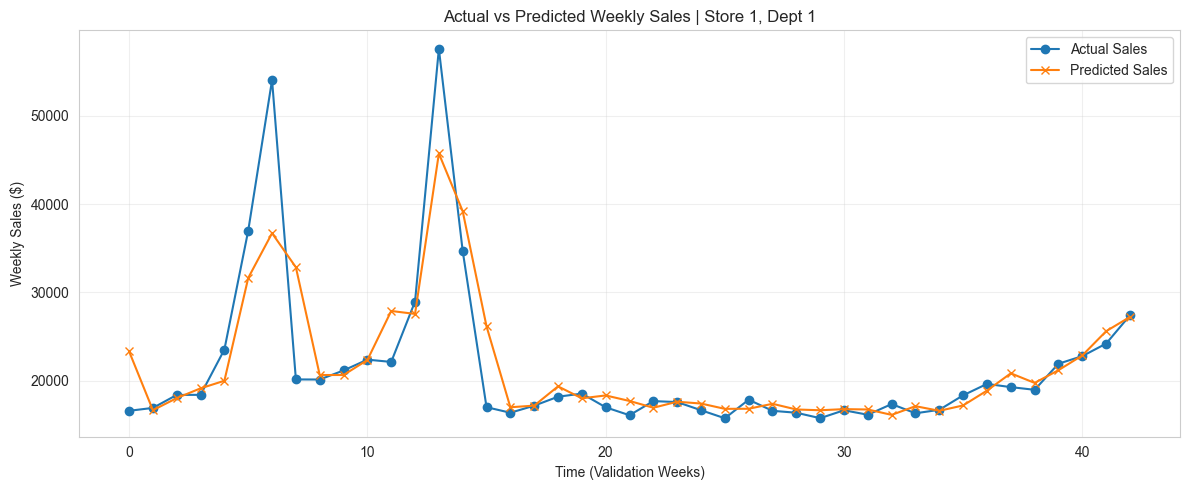

In [20]:
# ================================
# ACTUAL vs PREDICTED PLOT
# ================================

# Pick one Store-Dept combo with enough data
sample_store = val_results['Store'].iloc[0]
sample_dept = val_results['Dept'].iloc[0]

sample_df = val_results[
    (val_results['Store'] == sample_store) &
    (val_results['Dept'] == sample_dept)
].sort_index()

plt.figure(figsize=(12, 5))
plt.plot(sample_df['Actual_Sales'].values, label='Actual Sales', marker='o')
plt.plot(sample_df['Predicted_Sales'].values, label='Predicted Sales', marker='x')

plt.title(f'Actual vs Predicted Weekly Sales | Store {sample_store}, Dept {sample_dept}')
plt.xlabel('Time (Validation Weeks)')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()